In [1]:
import cv2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from scipy.ndimage.measurements import label

import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import helper as hp
from sklearn.model_selection import GridSearchCV

In [ ]:
def preprocess(image):
    
    median_kernel=3
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) #np.ones((5,5), np.uint8)
    
    opening_kernel_height=int(image.shape[0]/4)
    opening_kernel_width =int(image.shape[0]/30)
    opening_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(opening_kernel_width,opening_kernel_height))
    
    
    f, ( ax1, ax2, ax3, ax4 ) = plt.subplots(4, 1, figsize=(48, 18))
    f.tight_layout()
    
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,image = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    
    ax1.imshow(image,cmap='gray')
    ax1.set_title('grayscale', fontsize=50)
    
    #median blur
    median_image= cv2.medianBlur(image,median_kernel)  
    ax2.imshow(median_image, cmap='gray')
    ax2.set_title('medianBlur', fontsize=50)
    
    #morphological close
    closed_image=cv2.morphologyEx(median_image,cv2.MORPH_CLOSE,closing_kernel)
    ax3.imshow(closed_image, cmap='gray')
    ax3.set_title('closed_image', fontsize=50)
    
    #morphological_open
    open_image=cv2.morphologyEx(closed_image,cv2.MORPH_OPEN,opening_kernel)
    ax4.imshow(open_image, cmap='gray')
    ax4.set_title('open_image', fontsize=50)
    
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    return open_image

In [ ]:
def draw_labeled_bboxes(img, labels):
    
    candidates = []
    # Iterate through all detected cars
    for root_candidate in range(1, labels[1]+1):
        # Find pixels with each root_candidate label value
        nonzero = (labels[0] == root_candidate).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 2)
        
        
        height = np.max(nonzeroy) - np.min(nonzeroy)
        width = np.max(nonzerox) - np.min(nonzerox)
        
        candidates.append(img[np.min(nonzeroy): np.min(nonzeroy) + height,  
                                  np.min(nonzerox) :  np.min(nonzerox) + width ])
        
    # Return the image
    return img,candidates

In [ ]:
def find_candidates(processed_image,image):
    
    labels = label(processed_image)
    labelled_image, candidates = draw_labeled_bboxes(np.copy(image), labels)
    plt.imshow(labelled_image,cmap='gray')
    plt.show()
    
    return candidates

In [ ]:
images = glob.glob('test_images/*.png')

for fname in images:
    orig_image = cv2.imread(fname)
    
    
    processed_image = preprocess(image)

    candidates = find_candidates(processed_image,orig_image)
    
    print(len(candidates))    

In [ ]:
print(len(candidates))
for candidate in candidates:
    plt.imshow( candidate,cmap='gray' )
    plt.show()

In [2]:
# Read Training Images
roots   = glob.glob('/home/Anupam/backup/mb/Tree_Root_Detection/data/tree/*.JPG')
non_roots   = glob.glob('/home/Anupam/backup/mb/Tree_Root_Detection/data/non_tree/*.JPG')
non_roots   += glob.glob('/home/Anupam/backup/mb/Tree_Root_Detection/data/non_tree/*.jpg')
print(len(roots), len(non_roots))


51 52


In [3]:
# Augmentation
#Some useful image functions
img_size=64
def show3img(img, img1, img2):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Raw image")
    plt.subplot(1, 3, 2)
    plt.imshow(img1)
    plt.title("Processed image")
    plt.subplot(1, 3, 3)
    plt.imshow(img2)
    plt.title("Augmented image")
    plt.show()
    
def eq_Hist(img):
    #Histogram Equalization
    img2=img.copy() 
    img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img2

def scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
    return img2

def crop(img, mar=0):
    c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
    return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def transform_img(img):
    img2=sharpen_img(img)
    img2=crop(img2,3)
    img2=contr_img(img2, 1.5)
    return eq_Hist(img2)

def augment_img(img):
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=rotate_img(img)
    img=scale_img(img)
    return transform_img(img)


In [4]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
X_train_aug_roots = []
y_train_aug = []
X_val_prep = []

def create_data(n=10):
    for i in range(len(roots)):
        img=mpimg.imread(roots[i])
        img=cv2.resize(img, (64, 64)) 
        X_train_aug_roots.append(transform_img(img))
#         y_train_aug.append(y_train_sub[i])
        #Generate n new images out of each input image
        for j in range(n):
            X_train_aug_roots.append(augment_img(img))
#             y_train_aug.append(y_train_sub[i])       
    print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(10)

Total number of images in the augmented dataset =  561


In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
X_train_aug_nonroots = []
y_train_aug = []
X_val_prep = []

def create_data(n=10):
    for i in range(len(non_roots)):
        img=mpimg.imread(non_roots[i])
        img=cv2.resize(img, (64, 64)) 
        X_train_aug_nonroots.append(transform_img(img))
#         y_train_aug.append(y_train_sub[i])
        #Generate n new images out of each input image
        for j in range(n):
            X_train_aug_nonroots.append(augment_img(img))
#             y_train_aug.append(y_train_sub[i])       
    print("Total number of images in the augmented dataset = ", len(X_train_aug_nonroots))

create_data(10)

Total number of images in the augmented dataset =  572


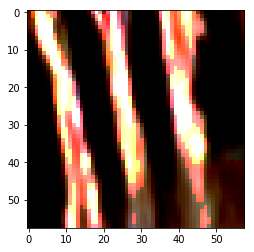

In [6]:
plt.imshow(X_train_aug_roots[102])

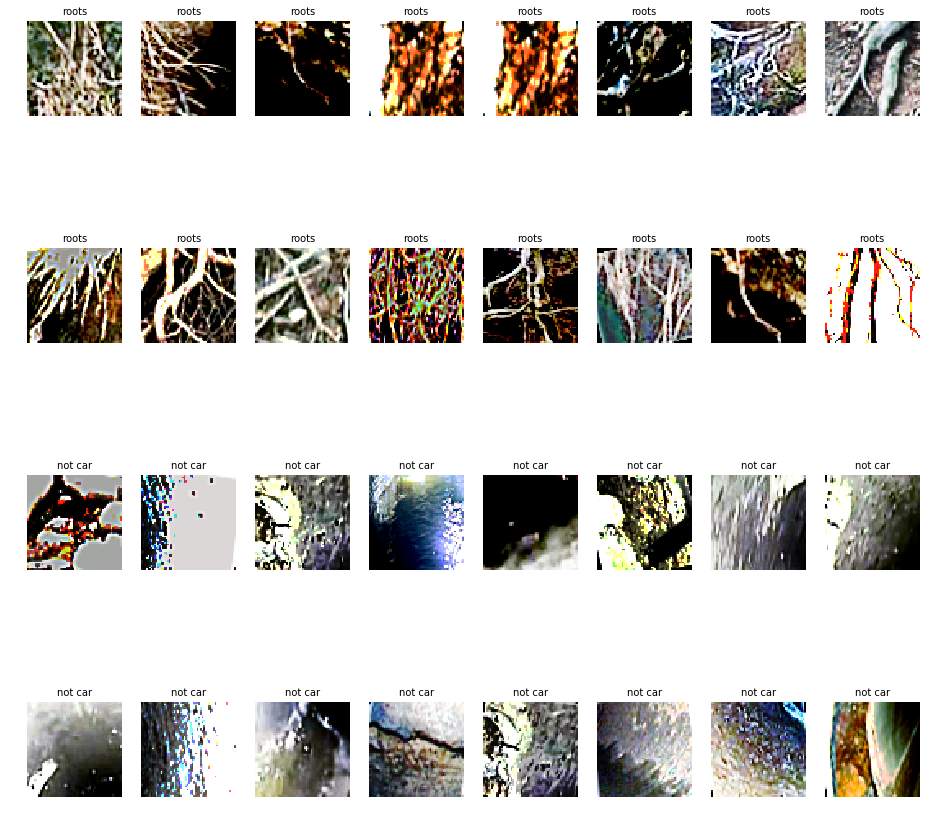

In [7]:
#visualize the data
fig, axs = plt.subplots(4,8, figsize=(16, 16))

axs = axs.ravel()

for i in np.arange(16):
    #img = mpimg.imread(X_train_aug_roots[np.random.randint(0,len(X_train_aug_roots))])
    img = X_train_aug_roots[np.random.randint(0,len(X_train_aug_roots))]
    axs[i].axis('off')
    axs[i].set_title('roots', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(16,32):
    #img = mpimg.imread(X_train_aug_nonroots[np.random.randint(0,len(X_train_aug_nonroots))])
    img = X_train_aug_nonroots[np.random.randint(0,len(X_train_aug_nonroots))]
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)

In [6]:

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, 
                     feature_vec=True,tnsfrm_sqrt=True):
                         
    # TODO: Complete the function body and returns
    return hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          transform_sqrt=tnsfrm_sqrt)#,block_norm="L2-Hys")

/home/Anupam/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/Anupam/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Text(0.5,1,'HOG Visualization')

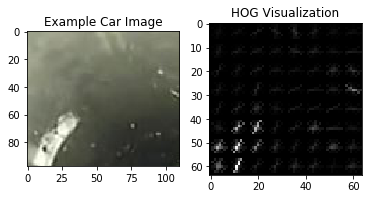

In [7]:
# Generate a random index to look at a car image
index = np.random.randint(0, len(non_roots))
# Read in the image
image = mpimg.imread(non_roots[index])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.resize(gray, (64, 64)) 
# Call our function with vis=True to see an image output
features, hog_img = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False,tnsfrm_sqrt=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Visualization')

In [8]:
#taken partially from class
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,tnsfrm_sqrt1=False,spatial_sz=(32,32),hst_bins=32):
    # Create a list to append feature vectors to
    features = []
    f=[]
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
#         image = mpimg.imread(file)
        image = file
        image = cv2.resize(image,(64,64))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True,tnsfrm_sqrt=tnsfrm_sqrt1))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True,tnsfrm_sqrt=tnsfrm_sqrt1)
            
        #Get color features
        spatial_features = hp.bin_spatial(feature_image, size=spatial_size)
        #hist_features = hp.color_hist(feature_image, nbins=hist_bins)
        
        #features.append(np.concatenate((spatial_features,hist_features,hog_features)))
        features.append(np.concatenate((spatial_features,hog_features)))
#         features.append(hog_features)
    return features

In [9]:
# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# colorspace = 'YUV' 
colorspace = 'RGB' 
orient = 11
pix_per_cell =8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
transform_sqrt=False   #True or False
spatial_size=(16,16)
hist_bins=8

t=time.time()
root_features = extract_features(X_train_aug_roots, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,tnsfrm_sqrt1=transform_sqrt,spatial_sz=spatial_size,hst_bins=hist_bins)

nonroot_features = extract_features(X_train_aug_nonroots, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,tnsfrm_sqrt1=transform_sqrt,spatial_sz=spatial_size,hst_bins=hist_bins)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')



/home/Anupam/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/Anupam/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


5.2 Seconds to extract HOG features...


In [10]:
#display length of a single feature vector
print(len(root_features[0]))
print(len(nonroot_features[0]))

7236
7236


In [11]:
#cod influenced by classroom section
#train a classifier  
# Create an array stack of feature vectors
X = np.vstack((root_features, nonroot_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(root_features)), np.zeros(len(nonroot_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#clf = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#    max_iter=-1, probability=False, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)
clf = SVC(kernel='rbf')
#clf = LinearSVC()
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = SVC()
# clf = GridSearchCV(svr, parameters)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7236
5.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [1. 1. 0. 1. 1. 0. 0. 1. 1. 1.]
For these 10 labels:  [1. 1. 0. 1. 1. 0. 0. 1. 1. 1.]
0.05261 Seconds to predict 10 labels with SVC


In [ ]:
import pickle

pickle_out = open("classifiers/SVM1.sav","wb")
pickle.dump(clf, pickle_out)
pickle_out.close()

In [ ]:
import pickle
clf = pickle.load( open("classifiers/SVM90.sav", "rb") )

In [12]:
# code influenced by classroom
# efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            plt.imshow(subimg)
            # Get color features
            spatial_features = hp.bin_spatial(subimg, size=spatial_size)
            hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [13]:


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes



(16, 16) 11
test_images/treeroot.JPG


/home/Anupam/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/Anupam/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


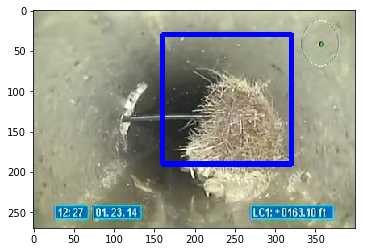

In [17]:
#plot find car
import pickle
ystart = 30
ystop = 270
scale = 2.5
#svc=pickle.load(open('classifiers/YUV_11orient_allFeatures_16spatialand8bins_8cells_transform_sqrtTrue', 'rb'))
#X_scaler=pickle.load(open('classifiers/YUV_11orient_allFeatures_16spatialand8bins_8cells_transform_sqrtTrue_scaler', 'rb'))
orient=11
pix_per_cell=8
cell_per_block=2
spatial_size=(16,16)
hist_bins=8
color_space='' #'RGB2HLS'  #'RGB2YCrCb'
print(spatial_size,orient)
test_images=glob.glob('test_images/*.JPG')

#plotting images for 1 scale
boxes=[]
for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    #plt.subplot(6,1,i)
    boxes=find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    #print(boxes[0][0])
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()